<a href="https://colab.research.google.com/github/agayev169/pytorch_examples/blob/master/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GPU

In [1]:
!nvidia-smi

Sat Dec 28 07:29:01 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Imports

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

## Model

### Encoder

In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 1, 3, 1)


    def forward(self, x):
        x = self.conv1(x) # x, 16, 26, 26
        x = torch.tanh(x)
        x = self.conv2(x) # x, 1, 12, 12
        x = torch.tanh(x)
        x = F.max_pool2d(x, 2)
        return x

### Decoder

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv1_t = nn.ConvTranspose2d(1, 16, 3, 2, output_padding=1)
        self.conv2_t = nn.ConvTranspose2d(16, 1, 3, 1)


    def forward(self, x):
        x = self.conv1_t(x) # x, 16, 26, 26
        x = torch.tanh(x)
        x = self.conv2_t(x) # x, 1, 28, 28
        x = torch.sigmoid(x)
        return x

### Autoencoder

In [0]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder


    def forward(self, x):
        return self.decoder(self.encoder(x))

### Test

In [0]:
def test(model, device, test_loader, epoch):
    model.eval()
    
    loss  = 0

    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            out = model(x)
            loss += F.mse_loss(out, x, reduction="sum").item()

    loss = loss / len(test_loader.dataset)

    print(f"TEST  --- epoch: {epoch:3d} --- loss: {loss:.6f}")

### Train

In [0]:
def train(model, device, train_loader, test_loader, optimizer, epochs_n):
    for epoch in range(epochs_n):
        model.train()
        
        epoch_loss = 0

        for batch_i, (x, _) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = F.mse_loss(out, x)
            loss.backward()
            optimizer.step()

            epoch_loss += F.mse_loss(out, x, reduction="sum").item()

        epoch_loss = epoch_loss / len(train_loader.dataset)

        print(f"TRAIN --- epoch: {(epoch + 1):3d} --- loss: {epoch_loss:.6f}")

        test(model, device, test_loader, epoch + 1)

## Constants

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 32
epochs_n   = 10
lr         = 0.001

## Data

In [0]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=True, download=True,
                  transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1037,), (0.3081,))
                  ])),
                  batch_size=batch_size, shuffle=True
    )

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("data/", train=False, download=True,
                  transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1037,), (0.3081,))
                  ])),
                  batch_size=batch_size, shuffle=True
    )

## Training

In [10]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = Autoencoder(encoder, decoder).to(device)

opt = optim.Adam(autoencoder.parameters(), lr=lr)

train(autoencoder, device, train_loader, test_loader, opt, epochs_n)

TRAIN --- epoch:   1 --- loss: 389.353023
TEST  --- epoch:   1 --- loss: 364.659861
TRAIN --- epoch:   2 --- loss: 357.735400
TEST  --- epoch:   2 --- loss: 361.966157
TRAIN --- epoch:   3 --- loss: 356.092430
TEST  --- epoch:   3 --- loss: 360.972494
TRAIN --- epoch:   4 --- loss: 355.411884
TEST  --- epoch:   4 --- loss: 360.510319
TRAIN --- epoch:   5 --- loss: 355.031955
TEST  --- epoch:   5 --- loss: 360.264174
TRAIN --- epoch:   6 --- loss: 354.801572
TEST  --- epoch:   6 --- loss: 360.110915
TRAIN --- epoch:   7 --- loss: 354.627943
TEST  --- epoch:   7 --- loss: 359.955976
TRAIN --- epoch:   8 --- loss: 354.476864
TEST  --- epoch:   8 --- loss: 359.883844
TRAIN --- epoch:   9 --- loss: 354.224848
TEST  --- epoch:   9 --- loss: 359.527745
TRAIN --- epoch:  10 --- loss: 354.032031
TEST  --- epoch:  10 --- loss: 359.562473


## Results

### Encoding

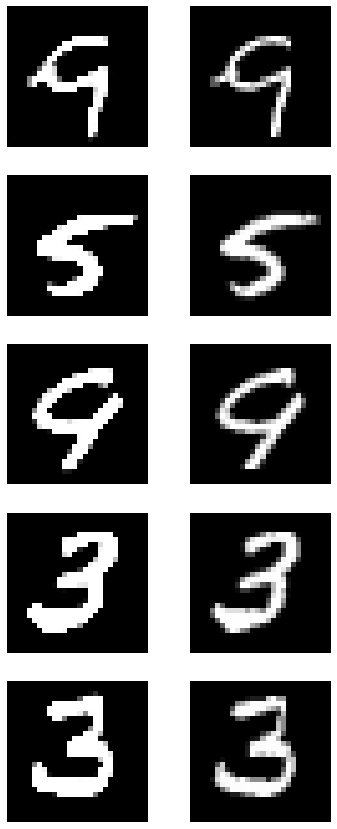

In [11]:
idxs = np.random.randint(0, len(train_loader.dataset), 5)
data_samples = torch.utils.data.Subset(train_loader.dataset, idxs)

fig, ax = plt.subplots(5, 2, figsize=(6, 15))

for i in range(len(idxs)):
    x, _ = data_samples[i]

    out = autoencoder(x.view(1, 1, 28, 28).to(device))
    out = out.to("cpu")
    out = out.detach().numpy().reshape(28, 28)
    ax[i, 0].imshow(out, cmap="gray")
    ax[i, 0].axis("off")

    x = x.numpy().reshape(28, 28)
    ax[i, 1].imshow(x, cmap="gray")
    ax[i, 1].axis("off")